
### Dataset
The source of the dataset  - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/). The repository has several datasets. For this case study, we are using the Tools and Home improvements dataset. The columns in this dataset are:
- **userId**
- **productId**
- **ratings**



In [184]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**Comments**
- **InteractiveShell** setting displays the full output for a cell, not just the latest one.
- Ignore all warnings in the notebook for an user friendly view
- **%matplotlib inline** sets the backend of matplotlib to the 'inline' backend: With this backend, the output of plotting commands is displayed inline without needing to call plt.show() every time a data is plotted.
- **sns.set()** sets few of the Seaborn's asthetic parameters
- Pandas **display.float_format** supress the scintific notation in pandas dataframe for easy readbability

---
## Q1. Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics)
### Load the Dataset

In [186]:
import pandas as pd

ratings = pd.read_csv('ratings100000.csv')

In [187]:
ratings.head()

,rating,userId,productId
0,3.000,0,0
1,5.000,1,0
2,4.000,2,0
3,4.000,3,0
4,4.000,4,0


In [188]:
# Check the head of the dataset
ratings.head()
# Check the tail of the dataset
ratings.tail()

,rating,userId,productId
0,3.000,0,0
1,5.000,1,0
2,4.000,2,0
3,4.000,3,0
4,4.000,4,0


,rating,userId,productId
99995,5.000,49333,772
99996,4.000,49334,772
99997,4.000,49334,772
99998,5.000,49335,772
99999,5.000,49335,772


**Comments**
- To take a closer look at the data, pandas library provides **“.head()”** function which returns first five observations and **“.tail()”** function which returns last five observations of the data set.

### Inspect the Dataset

In [189]:
# Get the shape and size of the dataset
print("Number of rows    :",ratings.shape[0])
print("Number of columns :",ratings.shape[1])

Number of rows    : 100000
Number of columns : 3


In [190]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   rating     100000 non-null  float64
 1   userId     100000 non-null  int64  
 2   productId  100000 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [191]:
# Check for any Null values in the dataset
ratings.isnull().sum()

rating       0
userId       0
productId    0
dtype: int64

In [192]:
# Get a dataframe consisting only of ratings that are duplicated
rating_combination = ['userId', 'productId']
ratings[ratings.duplicated(subset=rating_combination, keep=False)].sort_values(rating_combination).head()

,rating,userId,productId
60804,5.000,129,555
60805,5.000,129,555
59524,5.000,275,541
59525,5.000,275,541
384,5.000,384,8


In [193]:
# Check the count of unique user and product data
unique_original = (ratings.userId.nunique(), ratings.productId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 49336
Count of unique Products : 773


In [194]:
# Find the minimum and maximum ratings
print("The Minimum rating is:",ratings.rating.min())
print("The Maximum rating is:",ratings.rating.max())

The Minimum rating is: 1.0
The Maximum rating is: 5.0


Count of observations in each ratings:


5.000    70449
4.000    15219
3.000     5730
1.000     5288
2.000     3314
Name: rating, dtype: int64

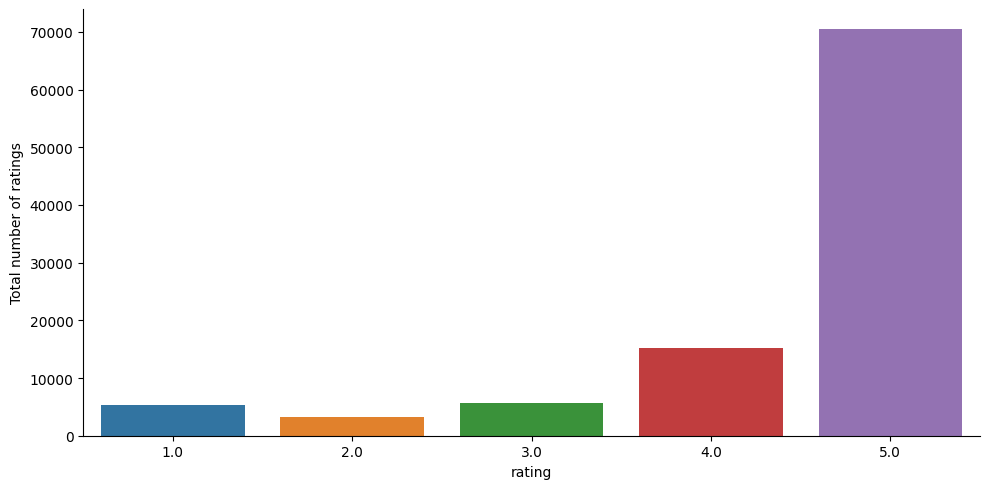

In [195]:
# Check the distribution of ratings 
print('Count of observations in each ratings:')
ratings.rating.value_counts()
g = sns.catplot(x="rating", data=ratings, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")

In [196]:
# Find the unique products under each ratings
ratings.groupby('rating')['productId'].nunique()

rating
1.000    425
2.000    387
3.000    477
4.000    642
5.000    735
Name: productId, dtype: int64

**Observations:**
- Extreme high count in rating 5 indicates Amazon delivers good quality products in Tools and Home Improvements department.
- Count plot and number of unique product under each rating category shows that there is more frequency under rating 5 followed by rating 4 and rating 1.
- This means ideally people are more sensitive towards extreme experiences. In other words more ratings can be observed when users are extremely satisfied or extremely unsatisfied.
- Users do not bother to rate usually for the average experience with any product, so is the reason rating 1, 2 and 3 are having lesser frequency compared to others.

---
## Q2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)
### Data Sparsity
Many recommender systems run into a problem called the **Cold-Start problem**. Essentially, a user can't be recommended anything because they haven't rated anything! Additionally, if you introduce a new product, nobody has rated it and it can't be recommended. Since we have rating data, we're going to run into either of these problems. Because of this problem, also the mathematical space becomes very much sparse.

If a user has rated one or very few items, how well could a recommender system work? If we have one point of a line, we have no idea which direction the line is going. In the same vein, if we have a user with only one or very few ratings, though we might be able to rule out some items, but it would be very difficult to be confident in our recommendations for that user.

For this reason, I'm going to explore how many ratings have been submitted per user.

In [197]:
# Find the top 10 users based on ratings
most_rated = ratings.userId.value_counts().rename_axis('UserId').reset_index(name='# ratings')
# most_rated = ratings.groupby('userId').size().sort_values(ascending=False)
most_rated.head(10)

,UserId,# ratings
0,9519,94
1,9420,80
2,9163,74
3,11012,64
4,10554,34
5,9403,30
6,9086,30
7,17449,28
8,8502,24
9,11937,24


### Density of the matrix
Density of a matrix can be described as the measure of closeness of datapoints to each other when the matrix is projected into a mathematical space with the no of dimensions equal to the column of the matrix and each row representing a point in that dimensional space. More the density of the matrix more close the data points are in the mathematical space forming a cloud or any other shape. When the data points are scattered far apart in the vector space, such matrix is called as a sparse matrix.

In [198]:
# Find the density of the rating matrix
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = ratings.userId.nunique() * ratings.productId.nunique()
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.5f}%'.format(density))

Total observed ratings in the dataset  : 100000
Total ratings possible for the dataset : 38136728
Density of the dataset                 : 0.26221%


**Getting rid of users who have rated less than 50 products**, as we can see the **density of the user-item matrix is 0.00039%**

In [199]:
# Drop the users who have rated less than 50 products
ratings = ratings[ratings.userId.isin(most_rated[most_rated['# ratings'] > 3].UserId)]
print('# unique USERS who have rated 3 or more products :', ratings.userId.nunique())
print('# unique USERS dropped      :', unique_original[0] - ratings.userId.nunique())
print('# unique ITEMS remaining    :', ratings.productId.nunique())
print('# unique ITEMS dropped      :', unique_original[1] - ratings.productId.nunique())
print('\nFinal length of the dataset :', len(ratings))

# unique USERS who have rated 3 or more products : 3211
# unique USERS dropped      : 46125
# unique ITEMS remaining    : 607
# unique ITEMS dropped      : 166

Final length of the dataset : 15721


**Observations:**
- There was a huge no of users (46007) who haven't rated atleast 3 products. These records would not have drawn a proper intuation about user similarity considering the total no. of records in the dataset. Hence we dropped all such users and are now left with **3329 unique users** with 3 or more ratings under each one's umbrella. Which is almost **6%** of total no of users in the original dataset.
- In the process of getting rid of such users, we ended up dropping 46007 unique products and their ratings. Now we are left with only **622 unique products** which is almost **80%** of the original list of products.
- As a whole we **dropped** 100000-16075=**93925 records** which is almost **94%** of the original dataset.

In [201]:
# Check for duplicate entries
if ratings.duplicated(subset=['userId', 'productId']).any():
    print("Duplicates found")
    # Handling duplicates - for example, by averaging the duplicate entries
    ratings = ratings.groupby(['userId', 'productId']).rating.mean().reset_index()

# Now you can pivot without duplicates
final_ratings_matrix = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)

print('Shape of final_ratings_matrix          :', final_ratings_matrix.shape)
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.2f}%'.format(density))

Duplicates found
Shape of final_ratings_matrix          : (3211, 607)
Total observed ratings in the dataset  : 7461
Total ratings possible for the dataset : 1949077
Density of the dataset                 : 0.38%



---
## Q5. Build Collaborative Filtering model
### Collaborative Filtering
Collaborative filtering is the process of filtering out information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources, etc.This is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a matter, A is more likely to have B's opinion on a different matter than that of a randomly chosen person.

This technique doesn’t need anything else except users’ historical preference on a set of items. Because it’s based on historical data. In terms of user preference, it usually expressed by two categories. 
- **Explicit Rating**: It is a rate given by a user to an item on a sliding scale, like 5 stars for any movie or an item. This is the most direct feedback from users to show how much they like an item. 
- **Implicit Rating**: This suggests users' preference indirectly, such as page views, clicks, purchase records, whether or not listen to a music track, and so on.

**Nearest Neighborhood** - The standard method of Collaborative Filtering is known as Nearest Neighborhood algorithm. 

**Types of Collaborative Filtering (CF)**
- Item Based Collaborative Filtering (IBCF)
  - Compute similarity between Items
- User Based Collaborative Filtering (UBCF)
  - Compute similarity between Users
  
**Similarity Metrics**: The following are the two popular similarity metrics used in recommender systems. **Jaccard Similarity** is useful when the User/Item Matrix contain binary values<br/>
- **Cosine Similarity**: Similarity is the cosine of the angle between the 2 item vectors represented by:
$$Cosine\;Similarity:CosSim(x,y)=\frac{\sum_i{x_iy_i}}{\sqrt{\sum{(x_i)^2}}\sqrt{\sum{(y_i)^2}}}=\frac{\langle x, y \rangle}{\|x\|\|y\|}$$

- **Pearson Correlation**: Similarity is the Pearson correlation between two vectors represented by:
$$Pearson\;Correlation:Corr(x, y)=\frac{\sum_i{(x_i-\bar{x})(y_i-\bar{y})}}{\sqrt{\sum{(x_i-\bar{x})^2}}\sqrt{\sum{(y_i-\bar{y})^2}}}=\frac{\langle x-\bar{x}, y-\bar{y} \rangle}{\|x-\bar{x}\|\|y-\bar{y}\|}=CosSim(x-\bar{x},\;y-\bar{y})$$

### User Based Collaborative Filtering (UBCF)
This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.
$$\widehat{r}_{ui}=\frac{\sum_{v\in{N_i^k(u)}}{similarity(u,v).r_{vi}}}{\sum_{v\in{N_i^k(u)}}{similarity(u,v)}}$$


First step is to create the sparse matrix. Let's attempt both UBCF.

In [202]:
# Create the User-Item sparse matrix
user_item = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (3211, 607)


productId,8,9,10,17,18,19,20,27,33,34,...,755,756,758,760,761,762,764,766,768,769
userId,,,,,,,,,,,,,,,,,,,,,
997,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1785,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2265,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2269,5.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2397,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Now, we will calculate the similarity. We can use the cosine_similarity function from sklearn to calculate the cosine similarity.

In [203]:

# Calculate the user-user similarity
user_similarity = cosine_similarity(user_item)
np.fill_diagonal(user_similarity, 0)
user_similarity_df = pd.DataFrame(user_similarity,index=user_item.index, columns=user_item.index)
print("User similarity")
user_similarity_df.head()

User similarity


userId,997,1785,2265,2269,2397,2446,3342,3440,3469,3698,...,48170,48276,48312,48319,48357,48371,48413,48414,48449,48566
userId,,,,,,,,,,,,,,,,,,,,,
997,0.000,0.128,0.137,0.157,0.109,0.137,0.128,0.083,0.137,0.174,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1785,0.128,0.000,0.355,0.408,0.284,0.355,0.333,0.214,0.355,0.451,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2265,0.137,0.355,0.000,0.435,0.303,0.379,0.355,0.229,0.379,0.481,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2269,0.157,0.408,0.435,0.000,0.348,0.870,0.408,0.263,0.435,0.552,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2397,0.109,0.284,0.303,0.348,0.000,0.303,0.284,0.354,0.303,0.384,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Now that we have both the smiliarity matrices in our hand, let's see the n-Neighborhood.

In [204]:

# Method to find top N neighbors
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(axis=1, func=lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                                   index=['top{}'.format(i) for i in range(1, n+1)]))
    return df

In [205]:

# Find 10 neighbors of each user
user_10_neighbors = find_n_neighbors(user_similarity_df, 10)
user_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
userId,,,,,,,,,,
997,15285,13922,14011,15276,8606,22377,22361,14383,13917,9549
1785,12282,9129,27063,17878,3698,3948,27011,14300,21823,15940
2265,22735,22729,22748,22763,22783,22794,22839,22731,28894,28781
2269,4045,2446,3698,3948,2265,3469,1785,3342,3929,3947
2397,29449,29448,29359,29362,29425,29453,29330,29394,27414,29862
2446,2269,4045,3947,43093,42830,41191,41189,42794,43047,42822
3342,3929,43676,20268,21925,20200,20251,20339,19948,3698,3948
3440,28306,17875,24058,24408,24471,24504,24409,24366,24460,24493
3469,10377,10372,10293,10414,10576,10232,10360,10570,10265,10403


Let's verify the similarity in both item and user base to find out if our calculatios are correct

In [206]:

def get_users_similar_products(user1, user2):
    common_products = ratings[ratings.userId == user1].merge(
    ratings[ratings.userId == user2],
    on = "productId",
    how = "inner" )
    return common_products[['rating_x', 'rating_y', 'productId']].head()

In [207]:
# Check the similarity of two users

get_users_similar_products(384, 974)

,rating_x,rating_y,productId


**Observations**:
- From the above step we can see that the similarity we generated is true since both the given users (**A100UD67AHFODS**, **A2FZQF0MH29VYN**) have almost same ratings and likings.

item_similarity and user_similarity are item-item and user-user similarity matrix in an array form respectively. The next step is to make predictions based on these similarities. Let’s define a function to do just that.

In [208]:

# Method to predict the rating
def predict(ratings, similarity, type='user'):
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred


Finally, we will make predictions based on user similarity and item similarity and recommend product based on similarity.

In [209]:

# Predict the ratings for both UBCF and IBCF
#st=time()
user_prediction = predict(user_item, user_similarity, type='user')
user_prediction = pd.DataFrame(user_prediction, index=user_item.index, columns=user_item.columns)
user_prediction.head(10)

productId,8,9,10,17,18,19,20,27,33,34,...,755,756,758,760,761,762,764,766,768,769
userId,,,,,,,,,,,,,,,,,,,,,
997,0.370,0.131,0.069,0.044,0.044,0.044,0.044,0.044,0.044,0.044,...,0.044,0.044,0.044,0.065,0.139,0.088,0.044,0.044,0.044,0.044
1785,2.040,0.578,0.168,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.149,0.004,0.004,0.004
2265,0.249,0.074,0.025,0.006,0.006,0.006,0.006,0.006,0.006,0.006,...,0.006,0.006,0.006,0.021,0.006,0.006,0.025,0.006,0.006,0.006
2269,4.778,1.500,0.323,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,...,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007
2397,0.373,0.102,0.033,0.005,0.005,0.005,0.012,0.005,0.005,0.005,...,0.005,0.005,0.005,0.005,0.035,0.005,0.005,0.005,0.005,0.005
2446,1.009,0.321,0.071,0.007,0.007,0.007,0.007,0.007,0.054,0.007,...,0.007,0.007,0.050,0.007,0.258,0.007,0.175,0.007,0.007,0.063
3342,0.994,0.262,0.078,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.055,0.004,0.004,0.004
3440,0.100,0.051,0.040,0.035,0.035,0.035,0.035,0.035,0.038,0.035,...,0.035,0.039,0.035,0.037,0.065,0.035,0.038,0.035,0.035,0.035
3469,0.451,0.131,0.040,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.038,0.004,0.004,0.004


In [210]:
# Function to apply sigmoid function to the predicted ratings
def predict_probability(ratings, similarity, type='user'):
    predicted_ratings = predict(ratings, similarity, type)
    # Apply the sigmoid function
    probability_pred = 1 / (1 + np.exp(-predicted_ratings))
    return probability_pred


In [211]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, preds_df, top_n):
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False)  # sorted_user_predictions
    # Prepare recommendations
    recommendations = sorted_user_predictions.rename_axis('Recommended Items').reset_index()
    recommendations.columns = ['Recommended Items', 'Predicted Rating']
    
    return recommendations.head(top_n)


In [216]:
# Generate Predicted Probabilities
user_prediction_prob = predict_probability(user_item, user_similarity, type='user')

# Convert Predicted Probabilities to DataFrame
user_prediction_df = pd.DataFrame(user_prediction_prob, index=user_item.index, columns=user_item.columns)

# Find recommendation for a couple of users using User-Based Collaborative Filtering (UBCF)
find_recom = {8576: 10, 8620:10, 3948: 10}  # This list is a user, top_n recommendation dictionary.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" % (find_recom[user], user))
    print(recommend_items(user, user_prediction_df, 5))
    print("\n")


Top 10 recommendations for the userId: 8576
   Recommended Items  Predicted Rating
0                 62             0.898
1                277             0.870
2                 57             0.791
3                511             0.574
4                 71             0.570


Top 10 recommendations for the userId: 8620
   Recommended Items  Predicted Rating
0                555             0.989
1                265             0.586
2                449             0.564
3                233             0.558
4                569             0.548


Top 10 recommendations for the userId: 3948
   Recommended Items  Predicted Rating
0                  8             0.992
1                  9             0.795
2                665             0.683
3                662             0.670
4                514             0.615




In [213]:
df_validation = pd.read_csv('validation_set.csv')

In [218]:
unique_users = df_validation['userId'].unique()

# Convert unique_users to a Pandas Series
unique_users_series = pd.Series(unique_users, name='userId')  # Add a name to the column
existing_users = unique_users_series[unique_users_series.isin(ratings['userId'].unique())]

# Create a DataFrame to store recommendations for users in df_validation
recommendations_existing_df = pd.DataFrame(columns=['userId', 'Recommendation 1', 'Predicted Rating 1', 'Recommendation 2', 'Predicted Rating 2', 'Recommendation 3', 'Predicted Rating 3', 'Recommendation 4', 'Predicted Rating 4', 'Recommendation 5', 'Predicted Rating 5'])
user_prediction_prob = predict_probability(user_item, user_similarity, type='user')
user_prediction_df = pd.DataFrame(user_prediction_prob, index=user_item.index, columns=user_item.columns)

# Find top 5 recommendations for each user in df_validation (existing users) and add them to recommendations_existing_df
for user in existing_users:
    recommendations = recommend_items(user, user_prediction_df, top_n=10)  # Use the modified function
    if not recommendations.empty:
        recommendations = recommendations.values[:5]
    else:
        recommendations = [['Not Exist', 0]] * 5
    recommendations_existing_df = recommendations_existing_df.append({'userId': user, 
                                                                      'Recommendation 1': recommendations[0][0], 'Predicted Rating 1': recommendations[0][1],
                                                                      'Recommendation 2': recommendations[1][0], 'Predicted Rating 2': recommendations[1][1],
                                                                      'Recommendation 3': recommendations[2][0], 'Predicted Rating 3': recommendations[2][1],
                                                                      'Recommendation 4': recommendations[3][0], 'Predicted Rating 4': recommendations[3][1],
                                                                      'Recommendation 5': recommendations[4][0], 'Predicted Rating 5': recommendations[4][1]}, ignore_index=True)

# Display the recommendations for existing users in df_validation
print("Recommendations for existing users in df_validation:")
recommendations_existing_df.head(2000)

Recommendations for existing users in df_validation:


,userId,Recommendation 1,Predicted Rating 1,Recommendation 2,Predicted Rating 2,Recommendation 3,Predicted Rating 3,Recommendation 4,Predicted Rating 4,Recommendation 5,Predicted Rating 5
0,11851.000,180.000,0.927,114.000,0.811,75.000,0.754,471.000,0.752,192.000,0.752
1,12440.000,129.000,0.989,104.000,0.679,436.000,0.564,151.000,0.555,241.000,0.547
2,9164.000,490.000,0.984,67.000,0.677,404.000,0.579,614.000,0.555,555.000,0.547
3,9259.000,597.000,0.887,449.000,0.842,69.000,0.701,555.000,0.611,511.000,0.611
4,11213.000,97.000,0.950,190.000,0.799,449.000,0.591,265.000,0.568,555.000,0.563
...,...,...,...,...,...,...,...,...,...,...,...
1521,17494.000,511.000,0.930,265.000,0.791,614.000,0.640,513.000,0.609,508.000,0.578
1522,8455.000,70.000,0.971,55.000,0.930,511.000,0.628,394.000,0.591,265.000,0.561
1523,14884.000,514.000,0.944,215.000,0.732,496.000,0.724,511.000,0.616,508.000,0.594
1524,10384.000,90.000,0.986,102.000,0.968,138.000,0.739,555.000,0.530,526.000,0.528


In [217]:
recommendations_existing_df.to_csv("recommendations_CF.csv", index=False)